In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_transform as tft
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import os
import pyts.image as pyti
import pyts.approximation as pyta
import re
import json

First let's define the model that we will use for the prediction. 

The model used in the paper is a slight variation of the standard CNN model from TensorFlow, which was used to classify images from Cifar-10 dataset.

In our case it will predict the wear class of the cutter from the 4 possibilities: "Break-in", "Steady", "Severe" and "Failure".

Our inputs are 3-layer RGB images, transformed via Gramian Angular Summation Field and smoothed out with PAA such that the shape of the input image is 256x256. 



In [35]:
input_shape = (512, 512, 3) # 3-channel 512x512 images

model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(64, (8, 8), strides=4, activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (8, 8), strides=4, activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(192),
    layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 127, 127, 64)      12352     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          262208    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0

Having the model we can create a pre-processing function which will take the input and turn it into images. 

In fact we can copy function `get_gasf` from previous notebook and apply few changes to it, and voila.


In [30]:
CSV_DIR='../../Datasets/PHM2010Challenge/c1/c1/'
IMAGE_DIR="Images/" # Save to current folder
LABELS=['Break_in', 'Steady_state', 'Severe', 'Failure']

def rescale(x, low=0, high=1):
    return (high - low) * (x - np.min(x)) / (np.max(x) - np.min(x)) + low

def filename_to_class(filename):
    # Create the label
    file_string = os.path.basename(filename)
    (_, _, cut_event, _) = re.split(r"_|\.", file_string)
    cut_event = int(cut_event)
    if cut_event < 50:
        label = LABELS[0]
    elif cut_event < 175:
        label = LABELS[1]
    elif cut_event < 250:
        label = LABELS[2]
    else:
        label = LABELS[3]
    return label

def get_gasf(cutter_sample):
    # Casting the time-domain data to RGB layers --- assume only appropriate columns are included
    cutter_acos = rescale(cutter_sample, low=-1, high=1)
    cutter_acos = np.arccos(cutter_acos)
    cutter_acos = np.asarray(cutter_acos).transpose()
    paa = pyta.PiecewiseAggregateApproximation(window_size=4)
    fcutter_paa = paa.transform(cutter_acos) # Piecewise Aggregate Approximation applied to the time-domain data
    nelem = fcutter_paa.shape[1]
    gasf = pyti.GramianAngularField(image_size=nelem, method='summation') # Grammar Angular Summation Field
    fcutter_gasf = gasf.transform(fcutter_paa)
    image = np.zeros((nelem, nelem, 3))
    for i in range(3):
        image[:,:,i] = fcutter_gasf[i, :, :]
    image = rescale(image, low=0, high=1)
    return image

def plot_gasf_contour(gasf_data): 
    if len(gasf_data.shape) == 3:
        (_, M, N) = gasf_data.shape
        gasf_data = gasf_data.reshape((M, N))
    else:
        assert(len(gasf_data.shape) == 2 and gasf_data.shape[0]==gasf_data.shape[1])
    # Make a contour plot
    fig, ax = plt.subplots()
    im = ax.contourf(gasf_data,
                cmap='rainbow_r',
                levels=80,
                alpha=0.8,
                vmin=0, vmax=1,
                origin='upper')
    fig.colorbar(im)
    plt.show()

def dataset_slices(filename, num_slices=3):
    cutter_sample = pd.read_csv(filename, header=None,
                    names=['Fx', 'Fy', 'Fz', 'Vx', 'Vy', 'Vz', 'aerms'],
                    usecols=['Fx', 'Fy', 'Fz'])
    nrow, ncol = cutter_sample.shape
    nelem = 2048
    start_idx = np.random.choice(nrow-nelem, num_slices)
    cutter_array = np.asarray(cutter_sample)
    dataset_sliced = np.zeros((num_slices, nelem, ncol))
    for i, _idx in enumerate(start_idx):
        dataset_sliced[i] = cutter_array[_idx:(_idx+nelem)]
    return start_idx, dataset_sliced

def populate_image_files(filename, num_files=3, image_dir=IMAGE_DIR):
    # From given file `filename` create `num_files` GASF images with image and label
    basename = re.split( r"\.", os.path.basename(filename))[0]
    start_idx, data_slices = dataset_slices(filename, num_slices=num_files)
    label = filename_to_class(filename)

    # Create the appropriate folder if non-existent
    class_dir = os.path.join(image_dir, label)
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    
    for i in range(num_files):
        gasf_image = get_gasf(data_slices[i])
        output_filename = os.path.join(class_dir, "%s-%s-%.3d.jpeg" % (label, basename, i))
        tf.keras.utils.save_img(output_filename, gasf_image)
    return start_idx


Even though it would be probably better to load directly the CSV files and preprocess them in the memory (not to create additional files on the disk), for simplicity we will create additional folder with the GASF images as RGB images, which can then be easily loaded to TensorFlow.

From each file we will take 3 continuous samples of size 2048 from different parts of the file.

In [31]:
filenames = os.listdir(CSV_DIR)
num_slices = 3

file_indexes_dict = {}
for i, filename in enumerate(filenames):
    if i % 50 == 0:
        print("Saving image: %s" % filename)
        print("------------ %d/%d" % (i, len(filenames)))
    
    idx = populate_image_files(os.path.join(CSV_DIR, filename),
                        num_files=num_slices, image_dir=IMAGE_DIR)
    file_indexes_dict[filename] = idx

print("Finished.")


Saving image: c_1_117.csv
------------ 0/315
Saving image: c_1_065.csv
------------ 50/315
Saving image: c_1_215.csv
------------ 100/315
Saving image: c_1_223.csv
------------ 150/315
Saving image: c_1_146.csv
------------ 200/315
Saving image: c_1_294.csv
------------ 250/315
Saving image: c_1_047.csv
------------ 300/315
Finished.


We will also save the `file_indexes_dict` to be able to get back to the indices in the original files. Since the numpy types are not json-serializable we will transform them to lists with Python types.

In [32]:
file_indexes_dict_list = {k: [int(x) for x in list(v)] for k, v in file_indexes_dict.items()}
with open("Images.json", "w") as json_file:
    json.dump(file_indexes_dict_list, json_file)

Maybe it was not the most elegant solution, but it's fine, at least we have a dataset where we exactly know the input images.

In [33]:
SEED=1234 # Using the same seed for both traning and validation datasets
img_height, img_width = 512, 512
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIR,
    seed=SEED,
    image_size=(img_height, img_width),
    color_mode='rgb',
    labels='inferred',
    validation_split=VALIDATION_SPLIT,
    subset='training',
    batch_size=BATCH_SIZE
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_DIR,
    seed=SEED,
    image_size=(img_height, img_width),
    color_mode='rgb',
    labels='inferred',
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    batch_size=BATCH_SIZE
)

Found 945 files belonging to 4 classes.
Using 662 files for training.
Found 945 files belonging to 4 classes.
Using 283 files for validation.


2022-05-21 17:20:54.277932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
EPOCHS = 30

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    steps_per_execution=2)


history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/30
7/7 [==============================] - 10s 1s/step - loss: 1.1773 - accuracy: 0.6224 - val_loss: 0.4627 - val_accuracy: 0.8127
Epoch 2/30
7/7 [==============================] - 9s 1s/step - loss: 0.5213 - accuracy: 0.7885 - val_loss: 0.4657 - val_accuracy: 0.7986
Epoch 3/30
7/7 [==============================] - 10s 1s/step - loss: 0.4303 - accuracy: 0.7900 - val_loss: 0.4585 - val_accuracy: 0.7809
Epoch 4/30
7/7 [==============================] - 9s 1s/step - loss: 0.3304 - accuracy: 0.8807 - val_loss: 0.4561 - val_accuracy: 0.8021
Epoch 5/30
7/7 [==============================] - 9s 1s/step - loss: 0.2913 - accuracy: 0.9018 - val_loss: 0.4173 - val_accuracy: 0.8269
Epoch 6/30
7/7 [==============================] - 9s 1s/step - loss: 0.2815 - accuracy: 0.9124 - val_loss: 0.4116 - val_accuracy: 0.8516
Epoch 7/30
7/7 [==============================] - 9s 1s/step - loss: 0.2475 - accuracy: 0.9260 - val_loss: 0.3947 - val_accuracy: 0.8445
Epoch 8/30
7/7 [=======================

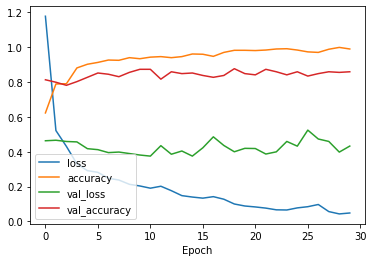

In [41]:
history_df = pd.DataFrame.from_dict( history.history )
history_df.plot()
plt.xlabel("Epoch")
plt.legend(loc='lower left')
plt.show()